## Unsupervised Learning | Project-2

*Please find below the Project 2 for Unsupervised Learning course.*

## Problem Statement 

Please find below the Project 2 for Unsupervised Learning course. This is an individual assignment. Kindly submit it before it's deadline.

The purpose of the case study is to classify a given silhouette as one of three different types of vehicle, using a set of features extracted from the silhouette. The vehicle may be viewed from one of many different angles.

Four "Corgie" model vehicles were used for the experiment: a double-decker bus, Chevrolet van, Saab 9000 and an Opel Manta 400 cars. This particular combination of vehicles was chosen with the expectation that the bus, van and either one of the cars would be readily distinguishable, but it would be more difficult to distinguish between the cars.

## Dataset 

vehicles.csv

### Overview:

- Data pre-processing - Understand the data and treat missing values (Use box plot), outliers (5 points)

- Understanding the attributes - Find the relationship between different attributes (Independent variables) and choose carefully which all attributes have to be a part of the analysis and why (5 points)

- Use PCA from scikit learn and elbow plot to find out a reduced number of dimension (which covers more than 95% of the variance) - 10 points

- Use Support vector machines and use grid search (try C values - 0.01, 0.05, 0.5, 1 and kernel = linear, rbf) and find out the best hyperparameters and do cross-validation to find the accuracy. (10 points)

## Import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Read the given Data

In [2]:
cars = pd.read_csv('Data/vehicles-project2.csv')

## 1. Data pre-processing - Understand the data and treat missing values (Use box plot), outliers (5 points)

In [3]:
cars.head()

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
0,95,48.0,83.0,178.0,72.0,10,162.0,42.0,20.0,159,176.0,379.0,184.0,70.0,6.0,16.0,187.0,197,van
1,91,41.0,84.0,141.0,57.0,9,149.0,45.0,19.0,143,170.0,330.0,158.0,72.0,9.0,14.0,189.0,199,van
2,104,50.0,106.0,209.0,66.0,10,207.0,32.0,23.0,158,223.0,635.0,220.0,73.0,14.0,9.0,188.0,196,car
3,93,41.0,82.0,159.0,63.0,9,144.0,46.0,19.0,143,160.0,309.0,127.0,63.0,6.0,10.0,199.0,207,van
4,85,44.0,70.0,205.0,103.0,52,149.0,45.0,19.0,144,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183,bus


In [4]:
cars['class'].value_counts()

car    429
bus    218
van    199
Name: class, dtype: int64

In [5]:
cars.info(), cars.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
compactness                    846 non-null int64
circularity                    841 non-null float64
distance_circularity           842 non-null float64
radius_ratio                   840 non-null float64
pr.axis_aspect_ratio           844 non-null float64
max.length_aspect_ratio        846 non-null int64
scatter_ratio                  845 non-null float64
elongatedness                  845 non-null float64
pr.axis_rectangularity         843 non-null float64
max.length_rectangularity      846 non-null int64
scaled_variance                843 non-null float64
scaled_variance.1              844 non-null float64
scaled_radius_of_gyration      844 non-null float64
scaled_radius_of_gyration.1    842 non-null float64
skewness_about                 840 non-null float64
skewness_about.1               845 non-null float64
skewness_about.2               845 non-null float64
hollows_ratio    

(None, (846, 19))

In [6]:
cars.isnull().any()

compactness                    False
circularity                     True
distance_circularity            True
radius_ratio                    True
pr.axis_aspect_ratio            True
max.length_aspect_ratio        False
scatter_ratio                   True
elongatedness                   True
pr.axis_rectangularity          True
max.length_rectangularity      False
scaled_variance                 True
scaled_variance.1               True
scaled_radius_of_gyration       True
scaled_radius_of_gyration.1     True
skewness_about                  True
skewness_about.1                True
skewness_about.2                True
hollows_ratio                  False
class                          False
dtype: bool

### Many columns are having Null values. We notice that the columns having Null values are all of float type. So, it will be ok to set the missing values as mean of rest of the values

In [7]:
for col in cars.columns:
    if (cars[col].isnull().any() == True):
        cars.loc[cars[col].isnull(), col] = cars[col].mean()

In [8]:
cars.isnull().any()

compactness                    False
circularity                    False
distance_circularity           False
radius_ratio                   False
pr.axis_aspect_ratio           False
max.length_aspect_ratio        False
scatter_ratio                  False
elongatedness                  False
pr.axis_rectangularity         False
max.length_rectangularity      False
scaled_variance                False
scaled_variance.1              False
scaled_radius_of_gyration      False
scaled_radius_of_gyration.1    False
skewness_about                 False
skewness_about.1               False
skewness_about.2               False
hollows_ratio                  False
class                          False
dtype: bool

### Now, Identifying and Processing the outliers

In [9]:
cars_sc = cars.drop('class', axis=1)
cars_sc = pd.DataFrame(data=StandardScaler().fit_transform(cars_sc), columns=cars_sc.columns)

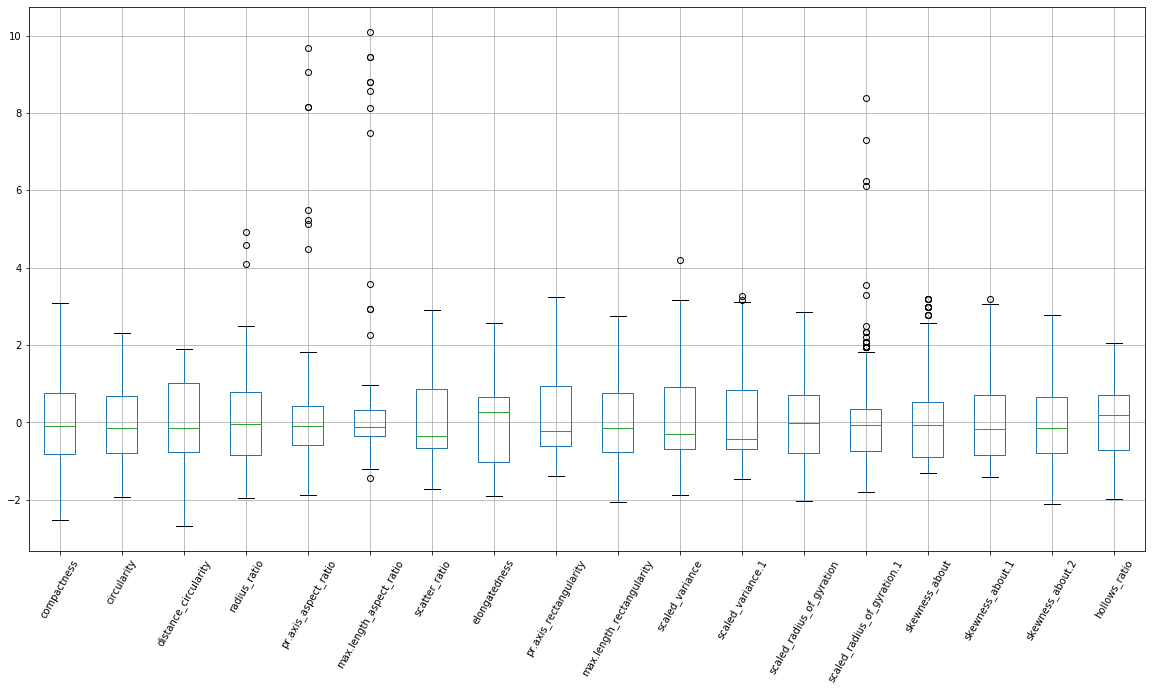

In [10]:
cars_sc.boxplot(figsize=(20, 10), rot=60)

#### From the above boxplot, there are quite a few variables with outliers. Identifying the datapoints, beyond +/-3 Sigma range and setting those points to the 3Sigma values.

In [11]:
for col in cars_sc.columns:
    if(len(cars.loc[stats.zscore(cars[col]) > 3]) > 0):
        cars.loc[stats.zscore(cars[col]) > 3, col] = cars[col].mean() + 3 * np.floor(cars[col].std())
    if(len(cars.loc[stats.zscore(cars[col]) < -3]) > 0):
        cars.loc[stats.zscore(cars[col]) < -3, col] = cars[col].mean() - 3 * np.floor(cars[col].std())

In [12]:
cars_sc = cars.drop('class', axis=1)
cars_sc = pd.DataFrame(data=StandardScaler().fit_transform(cars_sc), columns=cars_sc.columns)

In [13]:
#cars_sc.boxplot(figsize=(20, 10), rot=60)

## 2. Understanding the attributes - Find the relationship between different attributes (Independent variables) and choose carefully which all attributes have to be a part of the analysis and why (5 points)


In [14]:
le = LabelEncoder()

In [15]:
cars['class'] = le.fit_transform(cars['class'])

In [16]:
cars['class'].value_counts(), le.classes_

(1    429
 0    218
 2    199
 Name: class, dtype: int64, array(['bus', 'car', 'van'], dtype=object))

In [17]:
cars.corr()

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
compactness,1.000000,0.685527,0.790071,0.706622,0.155802,0.350103,0.812445,-0.788850,0.814032,0.676279,0.767118,0.816520,0.585155,-0.264830,0.234610,0.157891,0.298601,0.365597,-0.033821
circularity,0.685527,1.000000,0.793016,0.632265,0.192416,0.448464,0.848207,-0.821901,0.845205,0.961943,0.801090,0.838910,0.926888,0.055032,0.145601,-0.011041,-0.105645,0.045318,-0.159804
distance_circularity,0.790071,0.793016,1.000000,0.782919,0.219537,0.511793,0.904400,-0.911435,0.894279,0.774669,0.867164,0.888274,0.705953,-0.246278,0.114306,0.265972,0.145563,0.332095,-0.064902
radius_ratio,0.706622,0.632265,0.782919,1.000000,0.683312,0.481104,0.752529,-0.808698,0.728216,0.577693,0.796434,0.739771,0.546194,-0.304851,0.050969,0.178092,0.393259,0.482153,-0.194539
pr.axis_aspect_ratio,0.155802,0.192416,0.219537,0.683312,1.000000,0.309057,0.163455,-0.263633,0.135681,0.148098,0.247854,0.148920,0.146247,-0.186046,-0.057375,-0.028689,0.351853,0.374724,-0.170887
max.length_aspect_ratio,0.350103,0.448464,0.511793,0.481104,0.309057,1.000000,0.360164,-0.377815,0.357536,0.527661,0.390254,0.325934,0.322822,-0.121825,0.059689,0.106153,0.024993,0.305401,0.299221
scatter_ratio,0.812445,0.848207,0.904400,0.752529,0.163455,0.360164,1.000000,-0.970723,0.989221,0.808356,0.954013,0.993976,0.799266,-0.018711,0.074803,0.213631,0.005167,0.118448,-0.288904
elongatedness,-0.788850,-0.821901,-0.911435,-0.808698,-0.263633,-0.377815,-0.970723,1.000000,-0.949893,-0.775519,-0.942801,-0.955883,-0.766029,0.106080,-0.052777,-0.186002,-0.114727,-0.216719,0.339348
pr.axis_rectangularity,0.814032,0.845205,0.894279,0.728216,0.135681,0.357536,0.989221,-0.949893,1.000000,0.811971,0.939894,0.989246,0.796798,-0.004986,0.084029,0.216402,-0.017621,0.101381,-0.257735
max.length_rectangularity,0.676279,0.961943,0.774669,0.577693,0.148098,0.527661,0.808356,-0.775519,0.811971,1.000000,0.748931,0.796601,0.866425,0.042795,0.136681,0.002501,-0.104254,0.076770,-0.032399


### From the above matrix, following attributes are having low correlation (less than +/-0.1) with 'class' variable. Omitting those for further analysis:

- compactness, distance_circularity, max.length_rectangularity, skewness_about.1, skewness_about.2

In [18]:
low_corr_var = ['compactness', 'distance_circularity', 'max.length_rectangularity', 'skewness_about.1', 'skewness_about.2']

In [19]:
cars_reduced = cars.drop(low_corr_var, axis=1)

### Scikit-learn also has an utility to get the scores of all attributes against the target varaible. We will use that, get the scores and keep the attributes with higher scores

In [20]:
X = cars.drop('class', axis=1)
y = cars['class']

In [21]:
model = SelectKBest(score_func=chi2, k=4)
best = model.fit(X, y)

In [22]:
cols = pd.DataFrame(X.columns)
scores = pd.DataFrame(best.scores_)
featureScores = pd.concat([scores,cols],axis=1)
featureScores.columns = ['attrs', 'scores']

In [23]:
featureScores.sort_values(by='scores', ascending=False, inplace=True)
featureScores

,attrs,scores
16,2.111683,skewness_about.2
15,452.721145,skewness_about.1
14,117.119160,skewness_about
6,1257.176868,scatter_ratio
11,12686.561484,scaled_variance.1
10,859.102414,scaled_variance
13,94.193708,scaled_radius_of_gyration.1
12,454.183797,scaled_radius_of_gyration
3,947.603758,radius_ratio
8,56.465507,pr.axis_rectangularity


C:\Install\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Install\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


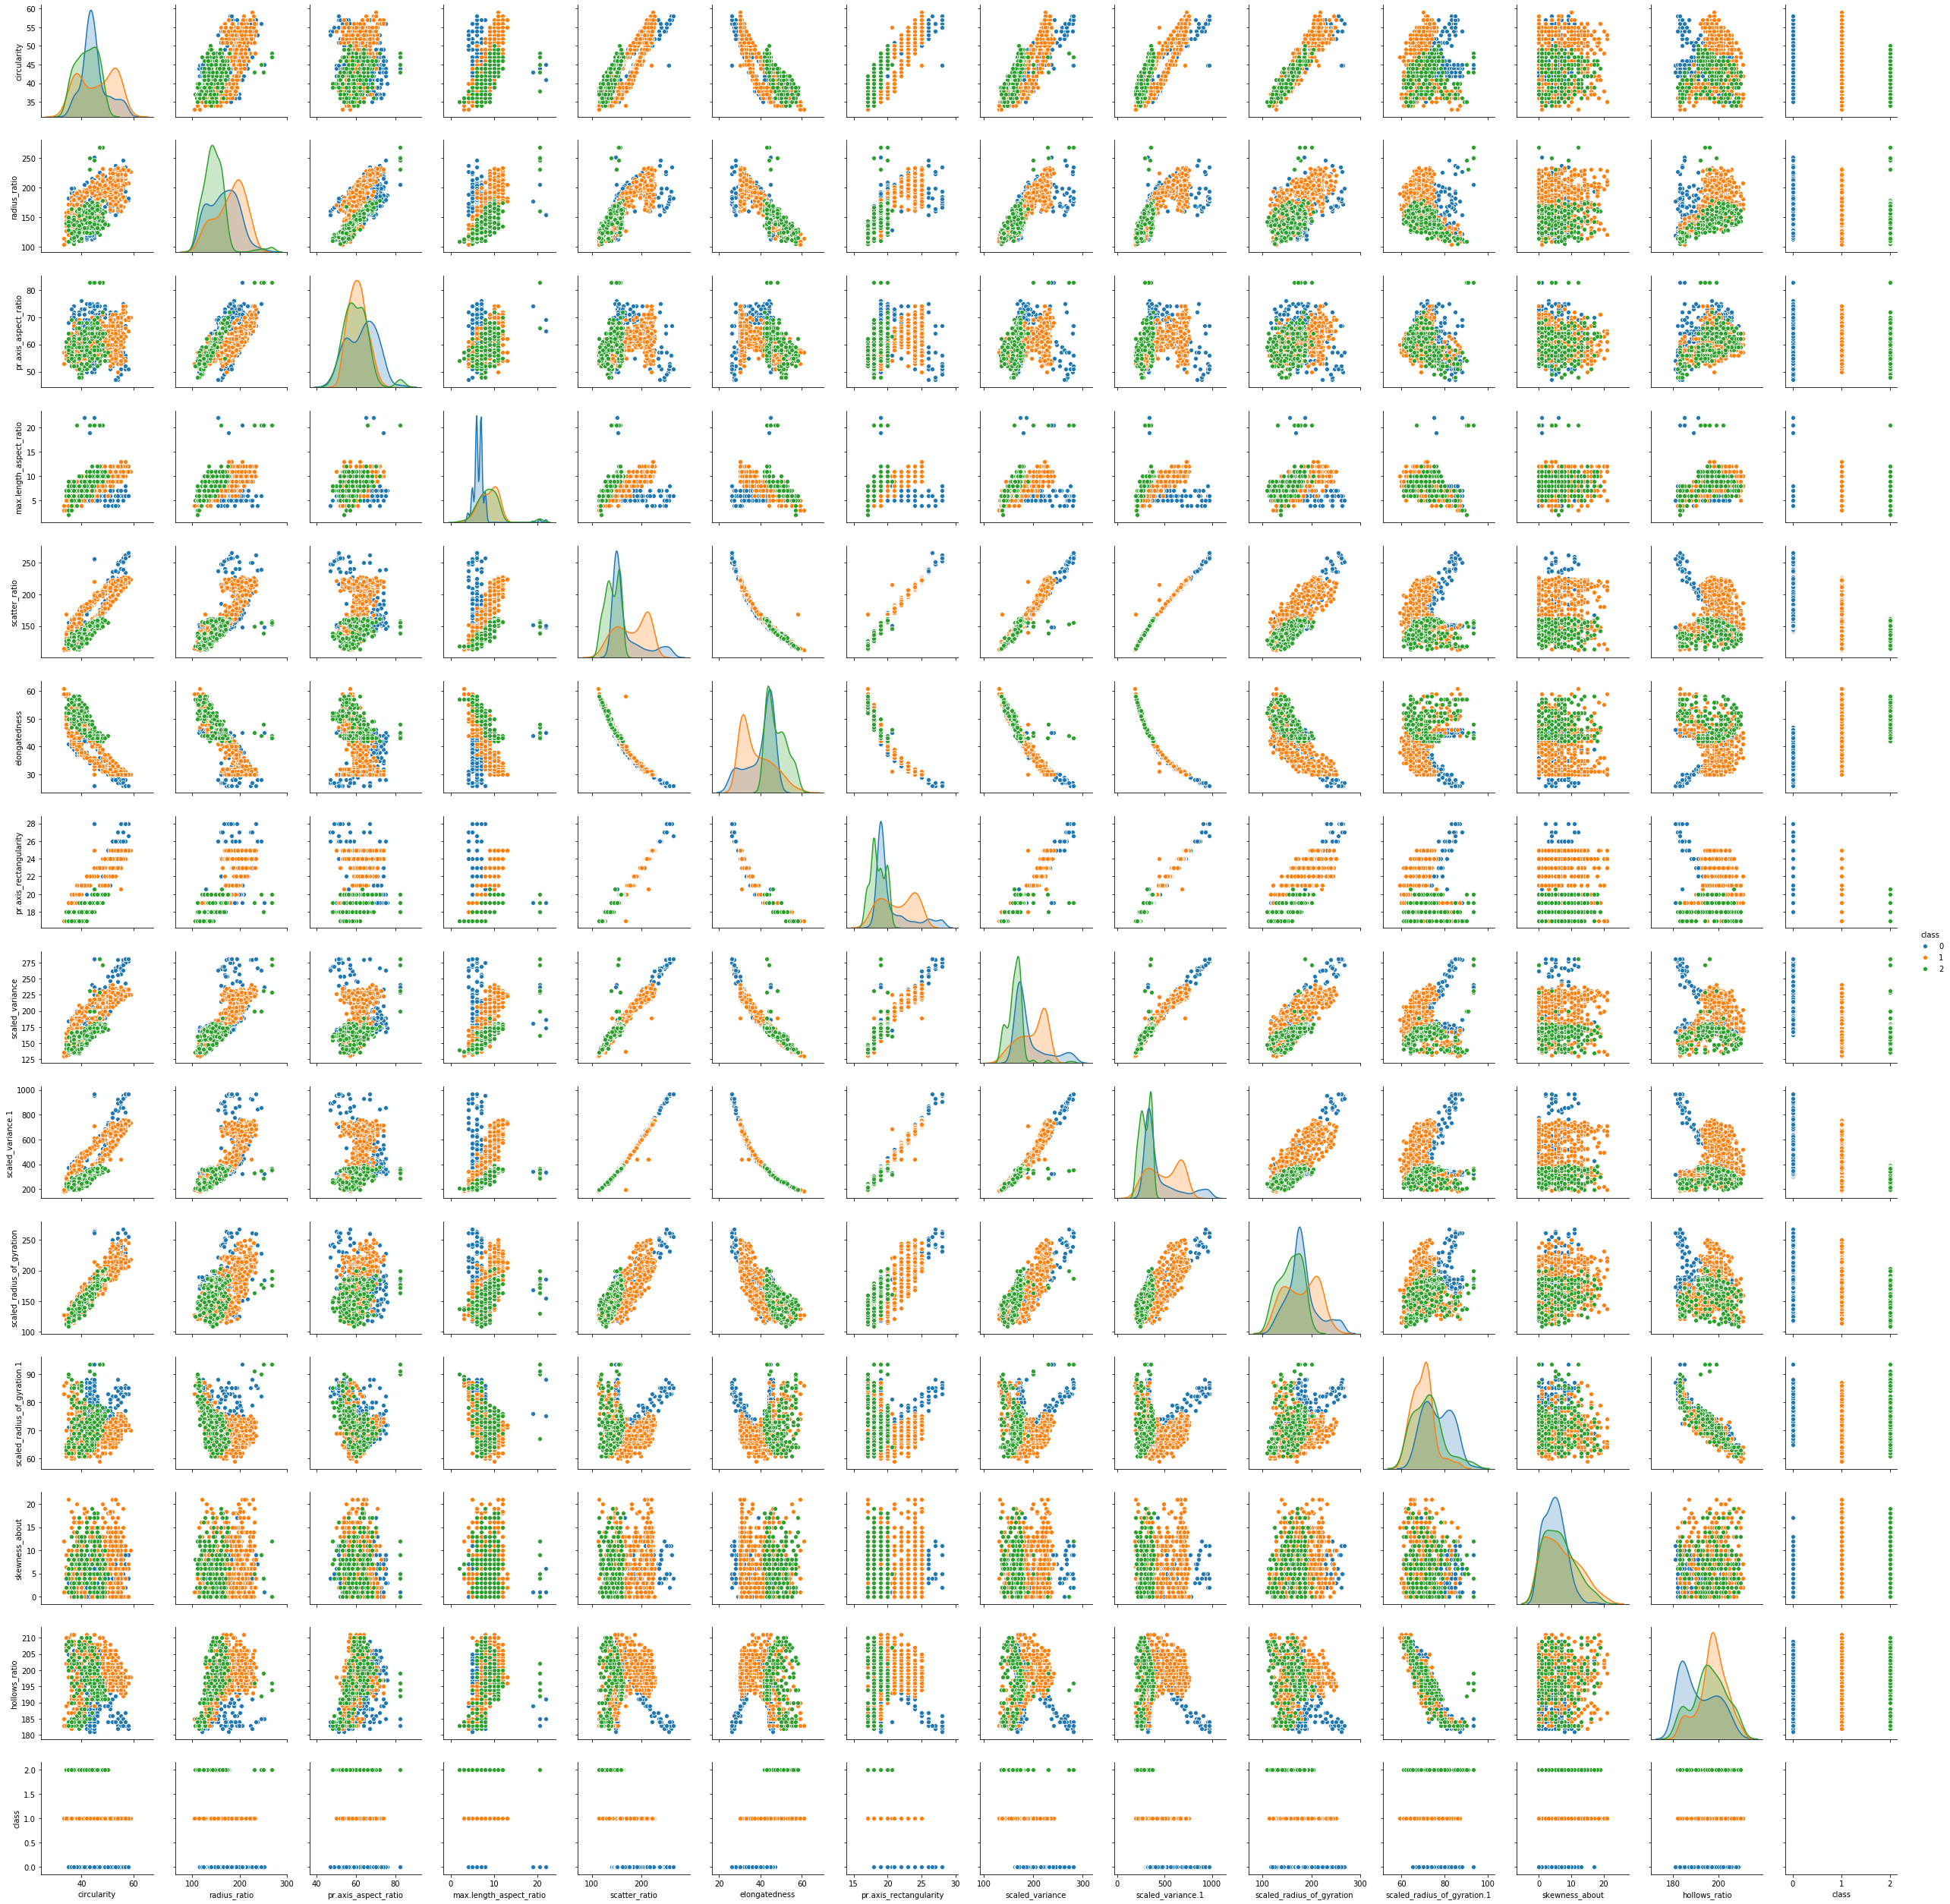

In [24]:
sns.pairplot(data=cars_reduced, hue='class')

### Following variables are having strong positive correlations with each other. Moreover, their correlation with other variables are also almost similar:

- scatter_ratio, pr.axis_rectangularity, scaled_variance, scaled_variance.1

Omitting three of them and keep only scaled_variance.1 which has highest feature scores among these four variables

In [25]:
high_corr_var = ['scatter_ratio', 'pr.axis_rectangularity', 'scaled_variance']

In [26]:
cars_reduced = cars_reduced.drop(high_corr_var, axis=1)

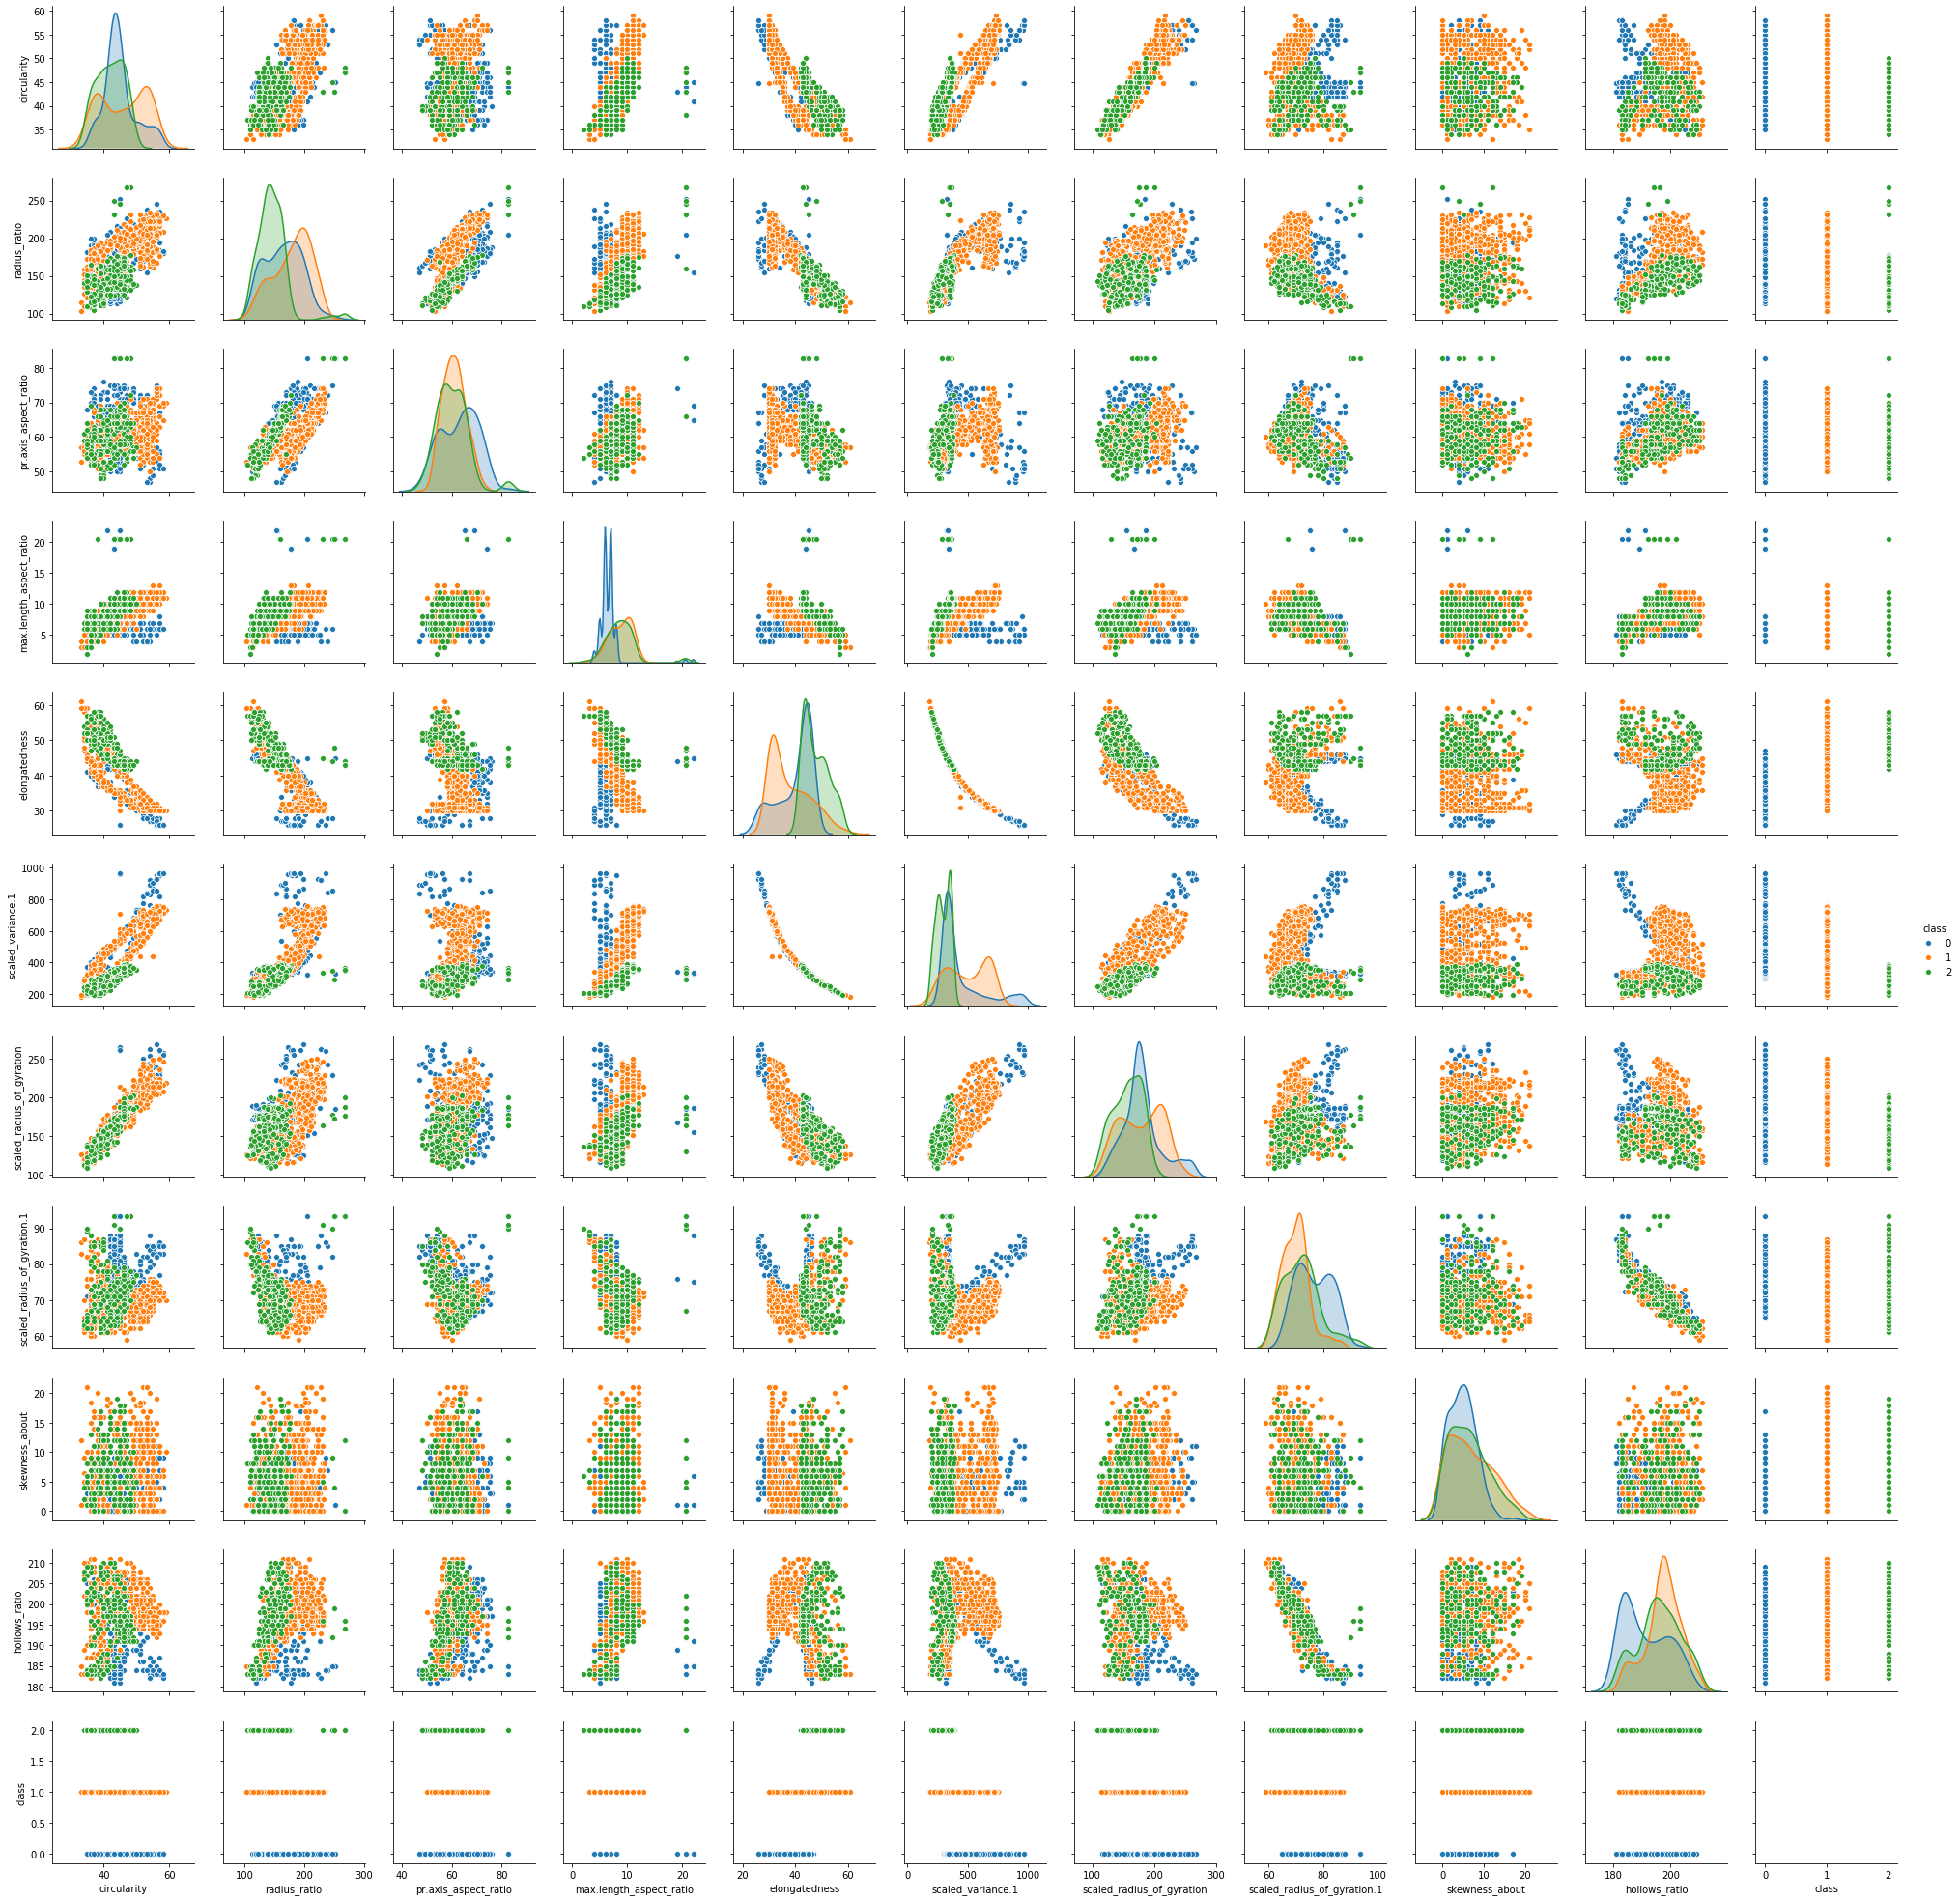

In [27]:
sns.pairplot(data=cars_reduced, hue='class')

### Above attributes show clear differentiation for 'class' values and so, we will keep them for analysis

### Distribution plots of above attributes show at least 3 bumps, which means there are at least 3 classes we expect in the overall dataset

In [28]:
cars_reduced.columns

Index(['circularity', 'radius_ratio', 'pr.axis_aspect_ratio',
       'max.length_aspect_ratio', 'elongatedness', 'scaled_variance.1',
       'scaled_radius_of_gyration', 'scaled_radius_of_gyration.1',
       'skewness_about', 'hollows_ratio', 'class'],
      dtype='object')

### Above 10 attributes are chosen for further analysis

## 3. Use PCA from scikit learn and elbow plot to find out a reduced number of dimension (which covers more than 95% of the variance) - 10 points

In [29]:
cars_sc = cars_reduced.drop('class', axis=1)
cars_sc = pd.DataFrame(data=StandardScaler().fit_transform(cars_sc), columns=cars_sc.columns)

In [30]:
X_sc = cars_sc

In [31]:
y = cars_reduced['class']

In [32]:
cov_matrix = np.cov(X_sc.T)

In [33]:
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

### These eigen values and vectors are not in order. Let's order them with eigen values in descending order by creating a temporarty dataframe

In [34]:
eigen_df = pd.DataFrame(eig_vecs)

In [35]:
eigen_df['eig_values'] = eig_vals

In [36]:
eigen_df.sort_values(by='eig_values', ascending=False, inplace=True)

In [37]:
eig_vals = eigen_df['eig_values'].to_numpy()

In [38]:
eigen_df.drop('eig_values', axis=1, inplace=True)

In [39]:
eig_vecs = eigen_df.to_numpy()

In [40]:
print('Eigen Values:')
eig_vals

Eigen Values:


array([4.60641261, 2.25197457, 1.10837075, 0.85041793, 0.69947581,
       0.28517306, 0.08166839, 0.0547123 , 0.04469873, 0.02893017])

In [41]:
print('Eigen Vectors:')
eig_vecs

Eigen Vectors:


array([[ 0.41495605, -0.20975235,  0.0899601 ,  0.02400947,  0.09887119,
        -0.4758735 ,  0.19074217,  0.67184843, -0.2248384 ,  0.02449193],
       [ 0.41652907,  0.18930999, -0.17386473, -0.05962113, -0.22290032,
         0.28571941,  0.36280449, -0.25587596, -0.65089943, -0.06922305],
       [ 0.20706474,  0.29378242, -0.47155546, -0.47645589, -0.46925589,
        -0.1723629 , -0.23796021,  0.15779404,  0.28716043, -0.08686837],
       [ 0.25950861,  0.12547223, -0.10330979, -0.47436385,  0.79756616,
         0.14323818, -0.06649828, -0.06235012,  0.06262333, -0.11116575],
       [-0.43546768,  0.07929289, -0.01310552, -0.24884264,  0.05980724,
        -0.34230542, -0.44994052, -0.0366407 , -0.64307886,  0.06242419],
       [ 0.41995277, -0.16538883,  0.06333544,  0.27412647, -0.04836721,
         0.37471665, -0.7412266 ,  0.11871678, -0.10229542,  0.02006631],
       [ 0.15166823,  0.59569019,  0.14300175,  0.15442448,  0.08141061,
        -0.10038539, -0.02425782, -0.01588906

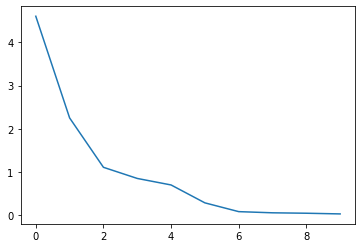

In [42]:
plt.plot(eig_vals)

In [43]:
tot = sum(eig_vals)
var_exp = [( ii /tot ) * 100 for ii in eig_vals]
cum_var_exp = np.cumsum(var_exp)
print("Cumulative Variance Explained:")
print(cum_var_exp)

Cumulative Variance Explained:
[ 46.00967676  68.50280334  79.57340954  88.06753658  95.05402666
  97.90238641  98.71810497  99.26458129  99.71104022 100.        ]


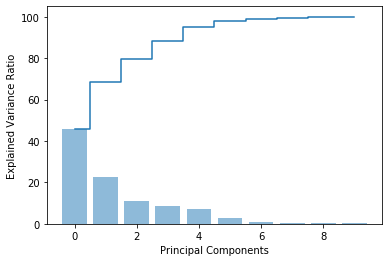

In [44]:
plt.bar(range(10), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(10), cum_var_exp, where='mid', label = 'Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.show()

### We will be taking 6 Principal Components which explains variance > 95%

In [45]:
pca = PCA(n_components=6)

In [46]:
X_reduced = pca.fit_transform(X_sc)

In [47]:
print('These are transformed features:')
X_reduced

These are transformed features:


array([[-0.83094727, -0.83863864,  0.84826467,  1.12008425, -0.24389471,
        -0.81811317],
       [ 1.2679562 , -0.39476516, -0.8221231 ,  0.2457627 ,  0.66545232,
         0.11594075],
       [-2.79174365,  0.35498564, -0.86909361,  1.01623585, -0.59942104,
         0.2424238 ],
       ...,
       [-3.54401137, -0.45989432,  0.90582004, -0.16667222,  0.57277307,
         0.19534711],
       [ 2.37739915, -0.93134709,  0.64524484, -0.95339281,  0.40061442,
        -0.23373822],
       [ 3.8223938 ,  0.17739452,  0.49197137, -0.76890078,  0.07912059,
        -0.20922722]])

In [63]:
print('These are transformed components:')
pd.DataFrame(pca.components_)

These are transformed components:


,0,1,2,3,4,5,6,7,8,9
0,-0.414956,-0.416529,-0.207065,-0.259509,0.435468,-0.419953,-0.380592,0.079251,-0.062992,-0.151668
1,0.209752,-0.189310,-0.293782,-0.125472,-0.079293,0.165389,0.309899,0.577492,-0.009648,-0.595690
2,-0.089960,0.173865,0.471555,0.103310,0.013106,-0.063335,-0.091948,0.260543,-0.792257,-0.143002
3,-0.024009,0.059621,0.476456,0.474364,0.248843,-0.274126,0.009342,0.330820,0.522870,-0.154424
4,0.098871,-0.222900,-0.469256,0.797566,0.059807,-0.048367,-0.031601,-0.055759,-0.259953,0.081411
5,-0.475873,0.285719,-0.172363,0.143238,-0.342305,0.374717,-0.538290,0.243578,0.157902,-0.100385


In [49]:
print('This is explained Variance Ratio:')
pca.explained_variance_ratio_

This is explained Variance Ratio:


array([0.46009677, 0.22493127, 0.11070606, 0.08494127, 0.0698649 ,
       0.0284836 ])

In [50]:
print('This is cummulative explained Variance Ratio:')
np.cumsum(pca.explained_variance_ratio_)

This is cummulative explained Variance Ratio:


array([0.46009677, 0.68502803, 0.7957341 , 0.88067537, 0.95054027,
       0.97902386])

### Above 6 principal components are sufficient to predict the variation (97%) instead of original 18 attributes

## 4. Use Support vector machines and use grid search (try C values - 0.01, 0.05, 0.5, 1 and kernel = linear, rbf) and find out the best hyperparameters and do cross-validation to find the accuracy. (10 points)

In [51]:
X = X_reduced
y = cars['class']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
svc = svm.SVC(C=0.05, kernel='linear', gamma='auto')

In [54]:
svc.fit(X_train, y_train)

SVC(C=0.05, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [55]:
print('Training Accuracy with random chosen hyperparameters: ', svc.score(X_train, y_train))
print('Testing Accuracy with random chosen hyperparameters: ', svc.score(X_test, y_test))

Training Accuracy with random chosen hyperparameters:  0.8313609467455622
Testing Accuracy with random chosen hyperparameters:  0.8529411764705882


In [56]:
c_values = [0.01, 0.05, 0.5, 1]
kernel = ['linear', 'rbf']
params = dict(C=c_values, kernel=kernel)

In [57]:
grid = GridSearchCV(estimator=svm.SVC(gamma='auto'), param_grid=params, cv=10)

In [58]:
grid_result = grid.fit(X_train, y_train)

C:\Install\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [59]:
print("Best Score: %f using best hyperparameters: %s" % (grid_result.best_score_, grid_result.best_params_))

Best Score: 0.920118 using best hyperparameters: {'C': 1, 'kernel': 'rbf'}


In [60]:
svc = svm.SVC(C=1, kernel='rbf', gamma='auto')

In [61]:
accuracy = cross_val_score(svc, X, y, cv=10, scoring='accuracy')

In [62]:
print('Mean Accuracy by cross-validation: ', accuracy.mean())

Mean Accuracy by cross-validation:  0.9183941381430621


### We see that Accuracy (0.91839) by choosing improved hyperparameters is much higher than that of with randomly chooosen parameters (0.85294)